In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os as os

path = "./results"

The load_curves function loads the results of multiple algorithms across different environments from .npy files, stores them in a dictionary structure, and processes them to ensure the curves all have the same length.

In [12]:
def load_curves(algorithms, envs, batch_sizes, hidden_sizes, t, path):
    """
    Load and process curves from saved files based on algorithms, environments, batch sizes, and hidden sizes.

    Args:
        algorithms (list): List of algorithm names.
        envs (list): List of environment names.
        batch_sizes (list): List of batch sizes used in the experiments.
        hidden_sizes (list): List of hidden sizes used in the experiments.
        t (int): Type of file to load (0 for regular, 1 for "_s" suffix).
        path (str): Path to the directory containing the data files.

    Returns:
        dict: Nested dictionary of curves {algorithm -> environment -> batch_size -> hidden_size -> [curves]}.
    """
    curves = {
        alg: {e: {hs: {bs: [] for bs in batch_sizes} for hs in hidden_sizes} for e in envs}
        for alg in algorithms
    }

    for alg in algorithms:
        for e in envs:
            for hidden_size in hidden_sizes:
                for batch_size in batch_sizes:
                    for i in range(0, 100):
                        suffix = "_s" if t == 1 else ""
                        name = f"{path}/{alg}_{hidden_size}_{batch_size}_{e}_{i}{suffix}.npy"
                        
                        if os.path.isfile(name):
                            curves[alg][e][hidden_size][batch_size].append(list(np.load(name)))
            
                    # Normalize the lengths of all curves for the current configuration
                    max_size = max(
                        (len(curve) for curve in curves[alg][e][hidden_size][batch_size]), default=-1
                    )
                    for i in range(len(curves[alg][e][hidden_size][batch_size])):
                        while len(curves[alg][e][hidden_size][batch_size][i]) < max_size:
                            curves[alg][e][hidden_size][batch_size][i].append(
                                curves[alg][e][hidden_size][batch_size][i][-1]
                            )

                    # Convert to numpy array for further processing
                    curves[alg][e][hidden_size][batch_size] = (
                        np.array(curves[alg][e][hidden_size][batch_size])
                        if len(curves[alg][e][hidden_size][batch_size]) else np.array([[]])
                    )

    return curves


The smooth function applies a smoothing technique to the loaded data by averaging over a window of neighboring points, creating a more visually appealing curve by reducing fluctuations.

In [13]:
def smooth(data, length=10):
    data = data.copy()
    pad = data[:, 0, None].repeat(length-1, axis=-1)
    pad_data = np.concatenate((pad, data), axis=-1)
    for i in range(len(data[0])):
        data[:, i] = np.mean(pad_data[:, i:i+length], axis=-1)
    return data

Compute the Frequency

In [14]:
def get_comput_freq(policy, batch_size, hidden_size):
    """
    Determines the computation frequency based on the policy, batch size, and hidden size.

    Args:
        policy (str): The name of the policy (e.g., "TD3", "ExpD3", etc.).
        batch_size (int): The batch size parameter.
        hidden_size (int): The hidden size parameter.

    Returns:
        float: The computation frequency (Hz).
    """
    if policy == "TD3":
        if batch_size == 32 and hidden_size == 32:
            return 1/20  # ~20 Hz
        elif batch_size == 64 and hidden_size == 32:
            return 1/17  # ~17 Hz
        elif batch_size == 128 and hidden_size == 32:
            return 1/12  # ~12 Hz
        elif batch_size == 32 and hidden_size == 64:
            return 1/13  # ~13 Hz
        elif batch_size == 64 and hidden_size == 64:
            return 1/9  # ~9 Hz
        elif batch_size == 128 and hidden_size == 64:
            return 1/5.9  # ~5.9 Hz
    elif policy == "OurDDPG":
        if batch_size == 32 and hidden_size == 32:
            return 1/20  
        elif batch_size == 64 and hidden_size == 32:
            return 1/17 
        elif batch_size == 128 and hidden_size == 32:
            return 1/12 
        elif batch_size == 32 and hidden_size == 64:
            return 1/13.7 
        elif batch_size == 64 and hidden_size == 64:
            return 1/9 
        elif batch_size == 128 and hidden_size == 64:
            return 1/5.8  
    elif policy == "ExpD3":
        if batch_size == 32 and hidden_size == 32:
            return 1/26  # ~26 Hz
        elif batch_size == 64 and hidden_size == 32:
            return 1/22  # ~22 Hz
        elif batch_size == 128 and hidden_size == 32:
            return 1/16.8  # ~16.8 Hz
        elif batch_size == 32 and hidden_size == 64:
            return 1/17  # ~17 Hz
        elif batch_size == 64 and hidden_size == 64:
            return 1/12.7  # ~12.7 Hz
        elif batch_size == 128 and hidden_size == 64:
            return 1/8  # ~8 Hz
    elif policy == "SAC":
        if batch_size == 32 and hidden_size == 32:
            return 1/20  
        elif batch_size == 64 and hidden_size == 32:
            return 1/17  
        elif batch_size == 128 and hidden_size == 32:
            return 1/12  
        elif batch_size == 32 and hidden_size == 64:
            return 1/13  
        elif batch_size == 64 and hidden_size == 64:
            return 1/9  
        elif batch_size == 128 and hidden_size == 64:
            return 1/5.9

    # Default frequency if no specific case matches
    return 1/10  # ~10 Hz

Plot the results

In [15]:
def plot_results_grid(ENVS, ALGORITHMS, BATCH_SIZES, HIDDEN_SIZES, curves, use_median):
    """
    Plots the performance curves for multiple algorithms with different batch and hidden sizes
    in a 3x2 grid, with all algorithms overlaid in each plot for different batch/hidden size combinations.
    
    Args:
        ENVS (list): List of environment names.
        ALGORITHMS (list): List of algorithm names.
        BATCH_SIZES (list): List of batch sizes.
        HIDDEN_SIZES (list): List of hidden sizes.
        curves (dict): Data for each algorithm, environment, batch size, and hidden size.
        use_median (bool): If True, use median with quartiles; if False, use mean with std deviation.
    """
    # Create the 3x2 grid of subplots
    fig, axes = plt.subplots(3, 2, sharex=True, figsize=(15, 10))
    axes = axes.flatten()  # Flatten the grid of axes for easier indexing

    # Loop over the grid of subplots (batch size and hidden size combinations)
    for idx, (hidden_size, batch_size) in enumerate([(32, 32), (64, 32), (32, 64), (64, 64), (32, 128), (64, 128)]):
        ax = axes[idx]  # Get the corresponding axis for this grid location
        ax.set_title(f"Batch {batch_size}, Neurons {hidden_size}", fontsize=16)
        ax.set_xlabel("Time [hours]")
        ax.set_ylabel("Success Rate" if use_median else "Reward")

        # Loop through each algorithm and plot its data for the current batch_size and hidden_size
        for alg_idx, alg in enumerate(ALGORITHMS):
            c = curves[alg][ENVS[0]][hidden_size][batch_size]
            if c.size == 0:
                print(f"No data for {alg} on {ENVS[0]} with batch {batch_size} and neurons {hidden_size}. Skipping.")
                continue

            # Get computation frequency for this combination
            delta_t = get_comput_freq(alg, batch_size, hidden_size)

            # Compute the time axis based on the sampling rate
            x = np.arange(c.shape[1]) * delta_t

            # Plot using median or mean depending on `use_median`
            if use_median:
                # Median and quartiles
                median = smooth(np.median(c, axis=0, keepdims=True), length=2).squeeze()
                q1 = smooth(np.percentile(c, 25, axis=0, keepdims=True), length=2).squeeze()
                q3 = smooth(np.percentile(c, 75, axis=0, keepdims=True), length=2).squeeze()
                ax.plot(x, median, label=f"{alg}", linewidth=2)
                ax.fill_between(x, q1, q3, alpha=0.2)
            else:
                # Mean and standard deviation
                mu = smooth(c.mean(axis=0, keepdims=True), length=2).squeeze()
                sigma = smooth(c.std(axis=0, keepdims=True), length=2).squeeze()
                ax.plot(x, mu, label=f"{alg}", linewidth=2)
                ax.fill_between(x, mu + sigma, mu - sigma, alpha=0.2)

        # Add grid and legend for each plot
        ax.grid(True)
        ax.legend(loc='best')

    # Adjust layout for better spacing and add a title for the entire figure
    fig.suptitle("Comparison of Algorithms across Batch and Neural Net Sizes", fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to avoid title overlap
    plt.show()


In [16]:
# Define parameters
ENVS = ['MR-env']
ALGORITHMS = ['OurDDPG', 'ExpD3', 'TD3', 'SAC']
BATCH_SIZES = [32, 64, 128]
HIDDEN_SIZES = [32, 64]

Plots the performance curves for each algorithm on each environment.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No data for OurDDPG on MR-env with batch 32 and neurons 32. Skipping.
No data for ExpD3 on MR-env with batch 32 and neurons 32. Skipping.
No data for TD3 on MR-env with batch 32 and neurons 32. Skipping.
No data for SAC on MR-env with batch 32 and neurons 32. Skipping.
No data for OurDDPG on MR-env with batch 32 and neurons 64. Skipping.
No data for ExpD3 on MR-env with batch 32 and neurons 64. Skipping.
No data for TD3 on MR-env with batch 32 and neurons 64. Skipping.
No data for SAC on MR-env with batch 32 and neurons 64. Skipping.
No data for OurDDPG on MR-env with batch 64 and neurons 32. Skipping.
No data for ExpD3 on MR-env with batch 64 and neurons 32. Skipping.
No data for TD3 on MR-env with batch 64 and neurons 32. Skipping.
No data for SAC on MR-env with batch 64 and neurons 32. Skipping.
No data for OurDDPG on MR-env with batch 64 and neurons 64. Skipping.
No data for ExpD3 on MR-env with batch 64 and neurons 64. Skipping.
No data for TD3 on MR-env with batch 64 and neurons 

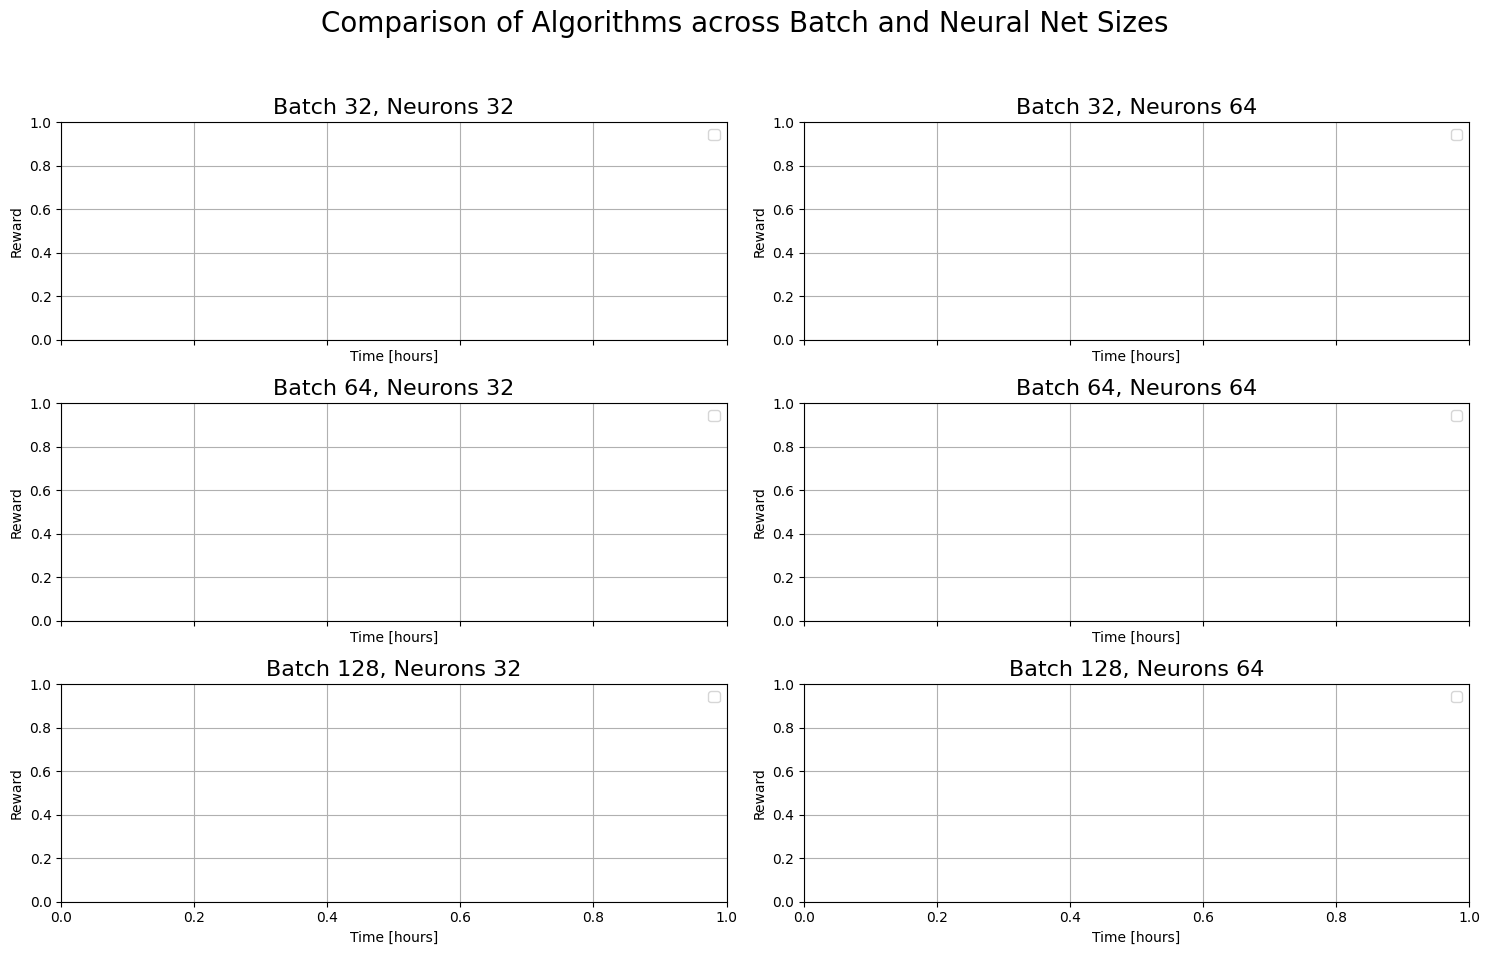

In [17]:
t = 0
# Load curves
curves = load_curves(ALGORITHMS, ENVS, BATCH_SIZES, HIDDEN_SIZES, t, path)
# Plot results
plot_results_grid(ENVS, ALGORITHMS, BATCH_SIZES, HIDDEN_SIZES, curves, use_median=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No data for OurDDPG on MR-env with batch 32 and neurons 32. Skipping.
No data for ExpD3 on MR-env with batch 32 and neurons 32. Skipping.
No data for TD3 on MR-env with batch 32 and neurons 32. Skipping.
No data for SAC on MR-env with batch 32 and neurons 32. Skipping.
No data for OurDDPG on MR-env with batch 32 and neurons 64. Skipping.
No data for ExpD3 on MR-env with batch 32 and neurons 64. Skipping.
No data for TD3 on MR-env with batch 32 and neurons 64. Skipping.
No data for SAC on MR-env with batch 32 and neurons 64. Skipping.
No data for OurDDPG on MR-env with batch 64 and neurons 32. Skipping.
No data for ExpD3 on MR-env with batch 64 and neurons 32. Skipping.
No data for TD3 on MR-env with batch 64 and neurons 32. Skipping.
No data for SAC on MR-env with batch 64 and neurons 32. Skipping.
No data for OurDDPG on MR-env with batch 64 and neurons 64. Skipping.
No data for ExpD3 on MR-env with batch 64 and neurons 64. Skipping.
No data for TD3 on MR-env with batch 64 and neurons 

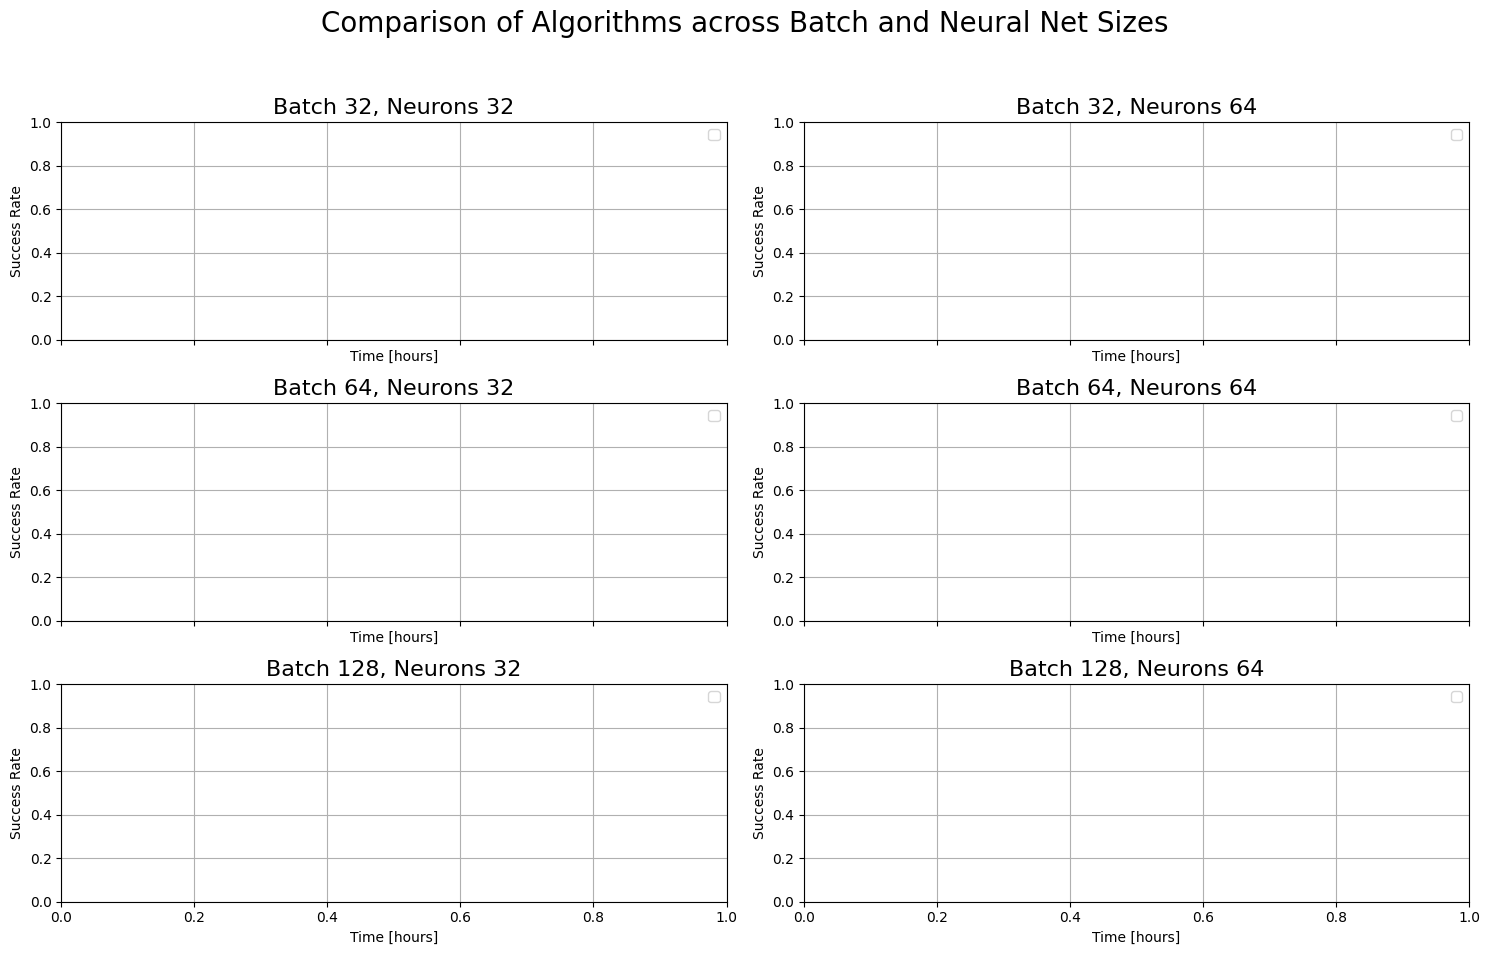

In [18]:
t = 1
# Load curves
curves = load_curves(ALGORITHMS, ENVS, BATCH_SIZES, HIDDEN_SIZES, t, path)
# Plot results
plot_results_grid(ENVS, ALGORITHMS, BATCH_SIZES, HIDDEN_SIZES, curves, use_median=True)

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def load_curves(algorithms, envs, batch_sizes, hidden_sizes, t, path, over_params=None, under_params=None):
    """
    Load and process curves from saved files based on algorithms, environments, batch sizes, 
    hidden sizes, and additional over/under parameters.
    """
    # Default parameters if not provided
    over_params = over_params or [0.5, 1, 1.5, 2]
    under_params = under_params or [0.5, 1, 1.5, 2]
    
    # Initialize the nested dictionary structure
    curves = {
        alg: {
            e: {
                hs: {
                    bs: {
                        (over, under): [] 
                        for over in over_params 
                        for under in under_params
                    } 
                    for bs in batch_sizes
                } 
                for hs in hidden_sizes
            } 
            for e in envs
        } 
        for alg in algorithms
    }
    
    # Iterate through all combinations
    for alg in algorithms:
        for e in envs:
            for hidden_size in hidden_sizes:
                for batch_size in batch_sizes:
                    for over in over_params:
                        for under in under_params:
                            for i in range(0, 100):
                                # Construct filename with additional parameters
                                suffix = "_s" if t == 1 else ""
                                
                                # Updated filename pattern to match your example
                                name = f"{path}/{alg}_{hidden_size}_{batch_size}_{e}_{over}_{under}_{i}{suffix}.npy"
                                
                                if os.path.isfile(name):
                                    print(f"Loading file: {name}")
                                    curves[alg][e][hidden_size][batch_size][(over, under)].append(list(np.load(name)))
    
    # Normalize and convert to numpy arrays
    for alg in algorithms:
        for e in envs:
            for hidden_size in hidden_sizes:
                for batch_size in batch_sizes:
                    for params, curve_list in curves[alg][e][hidden_size][batch_size].items():
                        # Skip if no curves
                        if not curve_list:
                            curves[alg][e][hidden_size][batch_size][params] = np.array([[]])
                            continue
                        
                        # Find max length
                        max_size = max((len(curve) for curve in curve_list), default=-1)
                        
                        # Pad shorter curves
                        for i in range(len(curve_list)):
                            while len(curve_list[i]) < max_size:
                                curve_list[i].append(curve_list[i][-1])
                        
                        # Convert to numpy array
                        curves[alg][e][hidden_size][batch_size][params] = np.array(curve_list)
    
    return curves

def plot_results_improved(curves, algorithms, envs, batch_sizes, hidden_sizes, use_median=False, max_plots_per_row=4):
    """
    Enhanced plotting function with 4-column grid visualization
    
    Args:
    - curves: Nested dictionary of curve data
    - algorithms: List of algorithms to plot
    - envs: List of environments
    - batch_sizes: List of batch sizes
    - hidden_sizes: List of hidden sizes
    - use_median: Whether to use median (True) or mean (False)
    - max_plots_per_row: Maximum number of plots in a single row
    """
    # Get all unique parameter combinations
    all_params = set()
    for alg in algorithms:
        for env in envs:
            for hidden_size in hidden_sizes:
                for batch_size in batch_sizes:
                    all_params.update(curves[alg][env][hidden_size][batch_size].keys())
    
    # Calculate grid dimensions
    num_params = len(all_params)
    num_cols = min(max_plots_per_row, num_params)
    num_rows = (num_params + num_cols - 1) // num_cols
    
    # Create subplots with increased figure size for better readability
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows))
    
    # Flatten axes for easier indexing if multiple rows
    if num_rows > 1:
        axes = axes.flatten()
    
    # More diverse and distinguishable color palette
    color_palettes = [
        plt.cm.tab10.colors,     # First palette
        plt.cm.Set1.colors,      # Second palette
        plt.cm.Set2.colors,      # Third palette
        plt.cm.Set3.colors,      # Fourth palette
        plt.cm.Paired.colors     # Fifth palette
    ]
    
    # Iterate through parameter combinations
    for idx, params in enumerate(sorted(all_params)):
        ax = axes[idx] if num_rows > 1 or num_cols > 1 else axes
        ax.set_title(f"Over:{params[0]}, Under:{params[1]}", fontsize=10)
        ax.set_xlabel("Hours", fontsize=8)
        ax.set_ylabel("Success Rate" if use_median else "Reward", fontsize=8)
        
        # Plot each algorithm for these parameters
        for alg_idx, alg in enumerate(algorithms):
            for batch_size_idx, batch_size in enumerate(batch_sizes):
                for hidden_size_idx, hidden_size in enumerate(hidden_sizes):
                    try:
                        # Get curves for specific parameters
                        c = curves[alg][envs[0]][hidden_size][batch_size][params]
                        
                        # Skip empty arrays
                        if c.size == 0:
                            continue
                        
                        # Get computation frequency for this combination
                        delta_t = get_comput_freq(alg, batch_size, hidden_size)

                        # Compute the time axis based on the sampling rate
                        x = np.arange(c.shape[1]) * delta_t
                        
                        # Select color from multiple palettes to increase distinctiveness
                        color_palette = [p[alg_idx % len(p)] for p in color_palettes]
                        color = color_palette[batch_size_idx % len(color_palette)]
                        
                        # Modify line style and color for additional distinction
                        linestyles = ['-', '--', '-.', ':']
                        linestyle = linestyles[hidden_size_idx % len(linestyles)]
                        
                        # Plot using median or mean
                        if use_median:
                            median = np.median(c, axis=0)
                            q1 = np.percentile(c, 25, axis=0)
                            q3 = np.percentile(c, 75, axis=0)
                            
                            label = f"{alg} (B:{batch_size},H:{hidden_size})"
                            ax.plot(x, median, 
                                    label=label, 
                                    color=color, 
                                    linestyle=linestyle,
                                    linewidth=2)
                            ax.fill_between(x, q1, q3, 
                                            color=color, 
                                            alpha=0.2)
                        else:
                            # Mean and standard deviation
                            mu = c.mean(axis=0)
                            sigma = c.std(axis=0)
                            
                            label = f"{alg} (B:{batch_size},H:{hidden_size})"
                            ax.plot(x, mu, 
                                    label=label, 
                                    color=color, 
                                    linestyle=linestyle,
                                    linewidth=2)
                            ax.fill_between(x, mu + sigma, mu - sigma, 
                                            color=color, 
                                            alpha=0.2)
                    
                    except KeyError:
                        continue
        
        # Add grid and legend
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='best', fontsize=6)
    
    # Hide any unused subplots
    if num_rows > 1 or num_cols > 1:
        for idx in range(len(all_params), len(axes)):
            fig.delaxes(axes[idx])
    
    # Adjust layout
    fig.suptitle(f"{'Median' if use_median else 'Mean'} Performance Across Parameters", fontsize=16)
    plt.tight_layout()
    plt.show()


# Updated load_and_plot_results function
def load_and_plot_results(path):
    algorithms = ['ExpD3']
    envs = ['MR-env']
    batch_sizes = [64, 128]
    hidden_sizes = [64]
    
    # Specify parameter combinations
    over_params = [0.5, 1.0, 1.5, 2.0]
    under_params = [0.5, 1.0, 1.5, 2.0]
    
    # Load and plot mean performance
    curves = load_curves(
        algorithms, envs, batch_sizes, hidden_sizes, 
        t=0, path=path,
        over_params=over_params,
        under_params=under_params
    )
    
    plot_results_improved(
        curves=curves, 
        algorithms=algorithms, 
        envs=envs, 
        batch_sizes=batch_sizes, 
        hidden_sizes=hidden_sizes, 
        use_median=False
    )

    # Load and plot median performance
    curves = load_curves(
        algorithms, envs, batch_sizes, hidden_sizes, 
        t=1, path=path,
        over_params=over_params,
        under_params=under_params
    )

    plot_results_improved(
        curves=curves, 
        algorithms=algorithms, 
        envs=envs, 
        batch_sizes=batch_sizes, 
        hidden_sizes=hidden_sizes, 
        use_median=True
    )

Loading file: ./results/ExpD3_64_64_MR-env_0.5_0.5_0.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_0.5_1.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_0.5_2.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_0.5_3.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_0.5_4.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_0.5_5.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_0.5_6.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_0.5_7.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_0.5_8.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_0.5_9.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_1.0_0.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_1.0_1.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_1.0_2.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_1.0_3.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_1.0_4.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_1.0_5.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_1.0_6.npy
Loading file: ./results/ExpD3_6

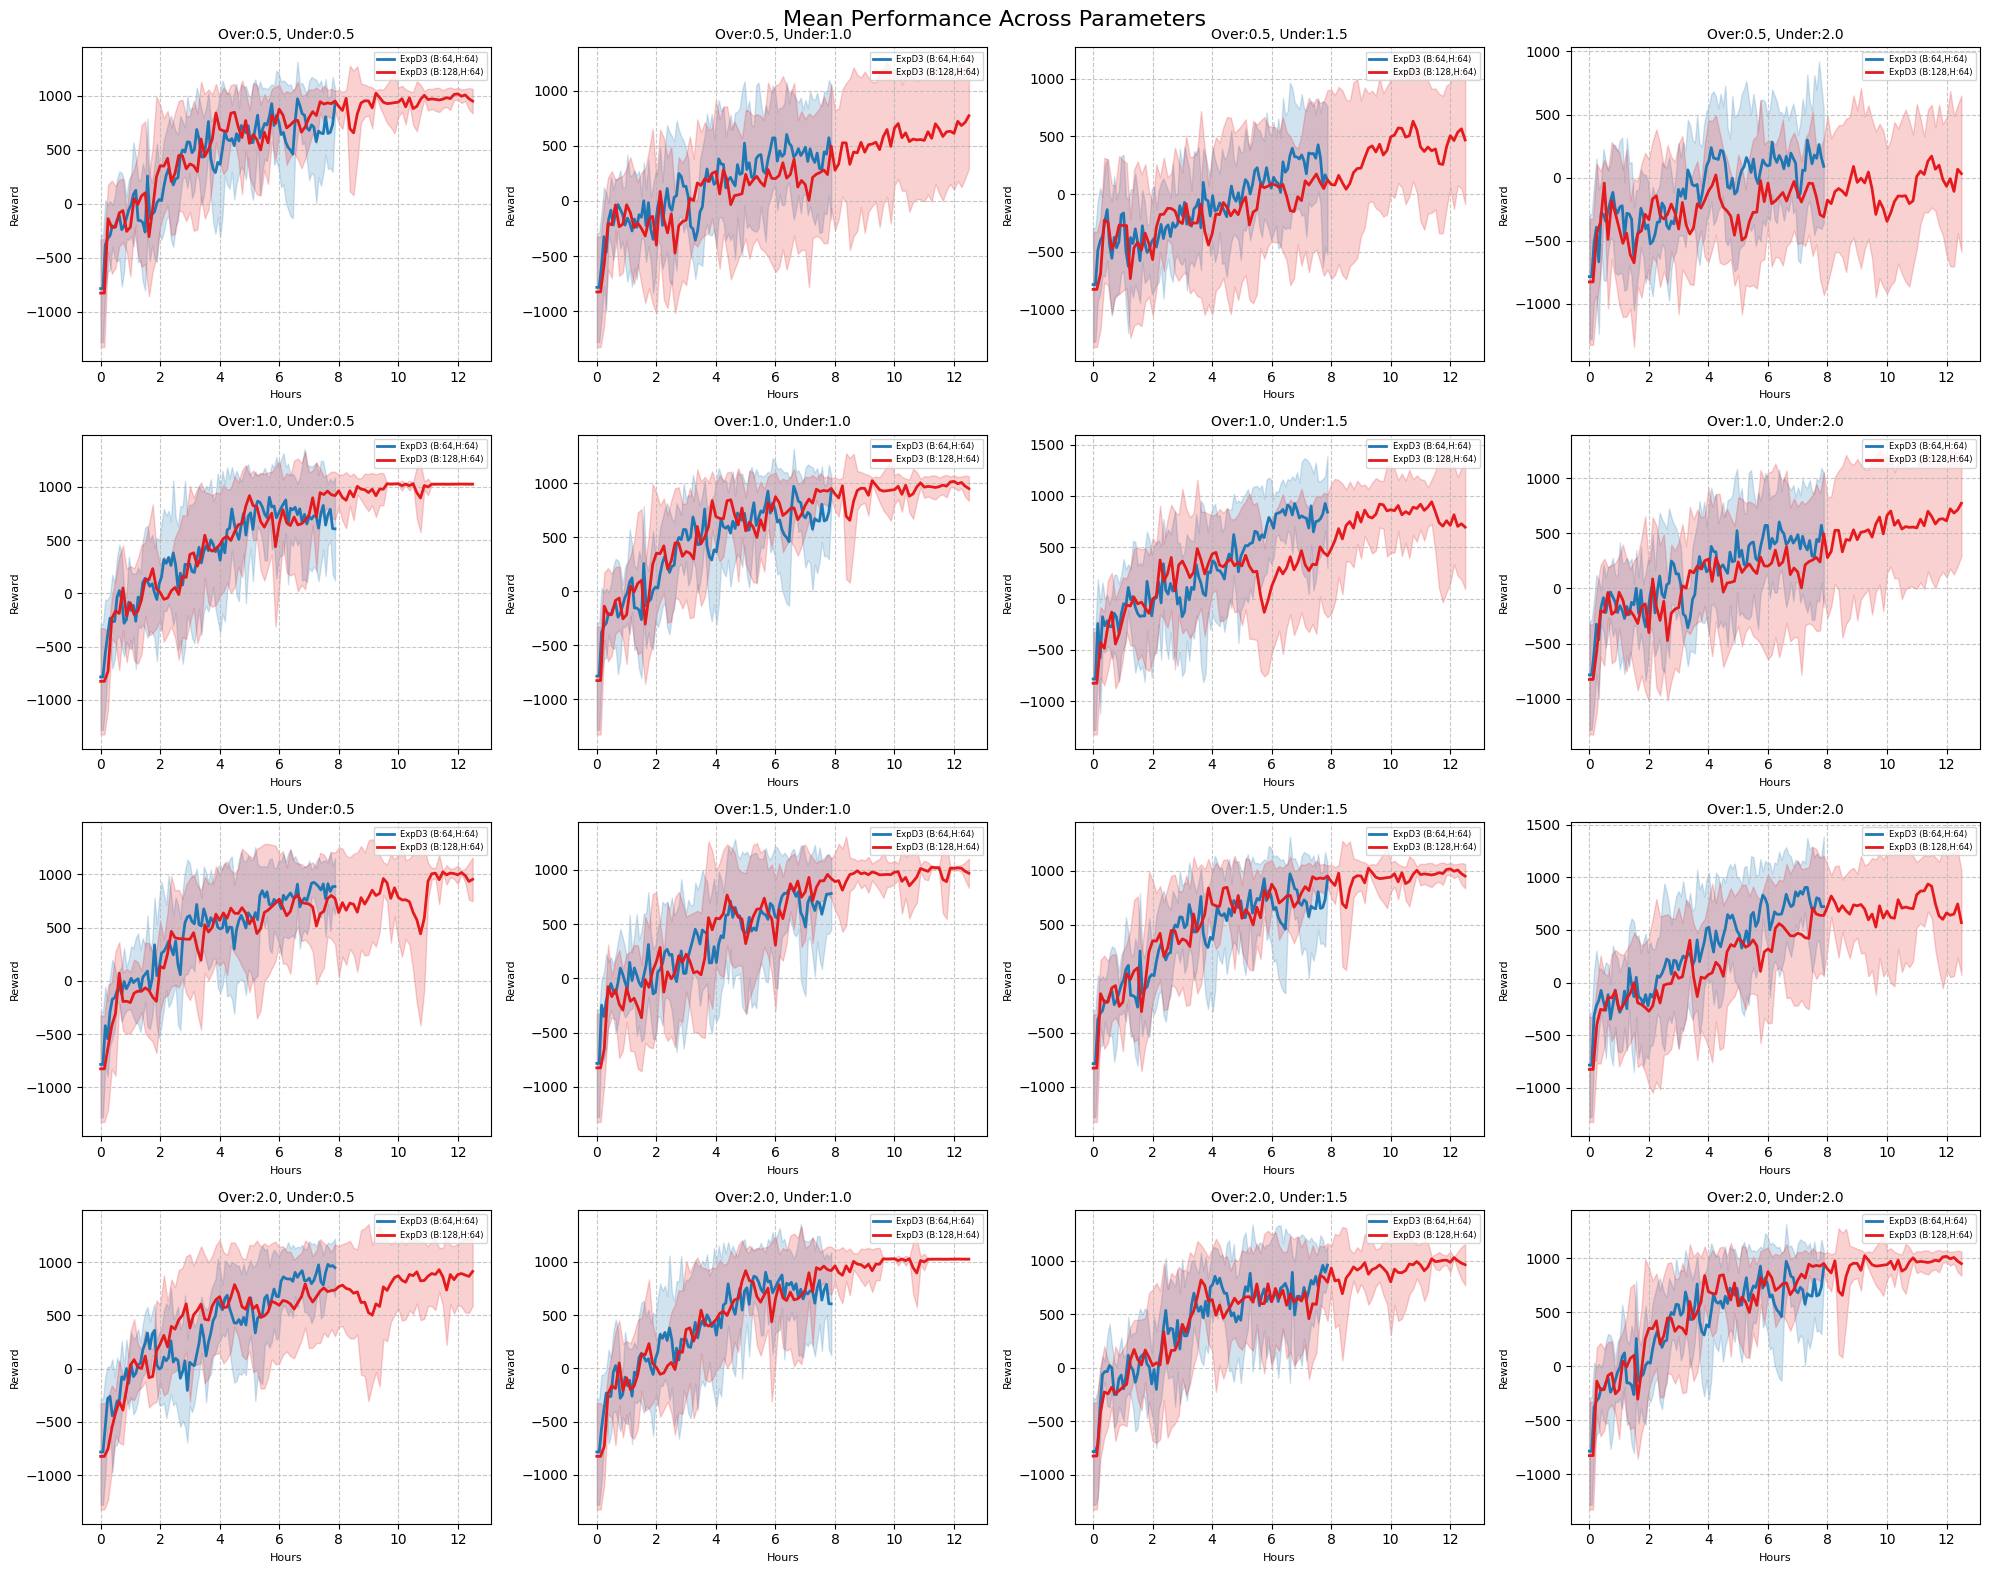

Loading file: ./results/ExpD3_64_64_MR-env_0.5_0.5_0_s.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_0.5_1_s.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_0.5_2_s.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_0.5_3_s.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_0.5_4_s.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_0.5_5_s.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_0.5_6_s.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_0.5_7_s.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_0.5_8_s.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_0.5_9_s.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_1.0_0_s.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_1.0_1_s.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_1.0_2_s.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_1.0_3_s.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_1.0_4_s.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_1.0_5_s.npy
Loading file: ./results/ExpD3_64_64_MR-env_0.5_1.0_6_s.n

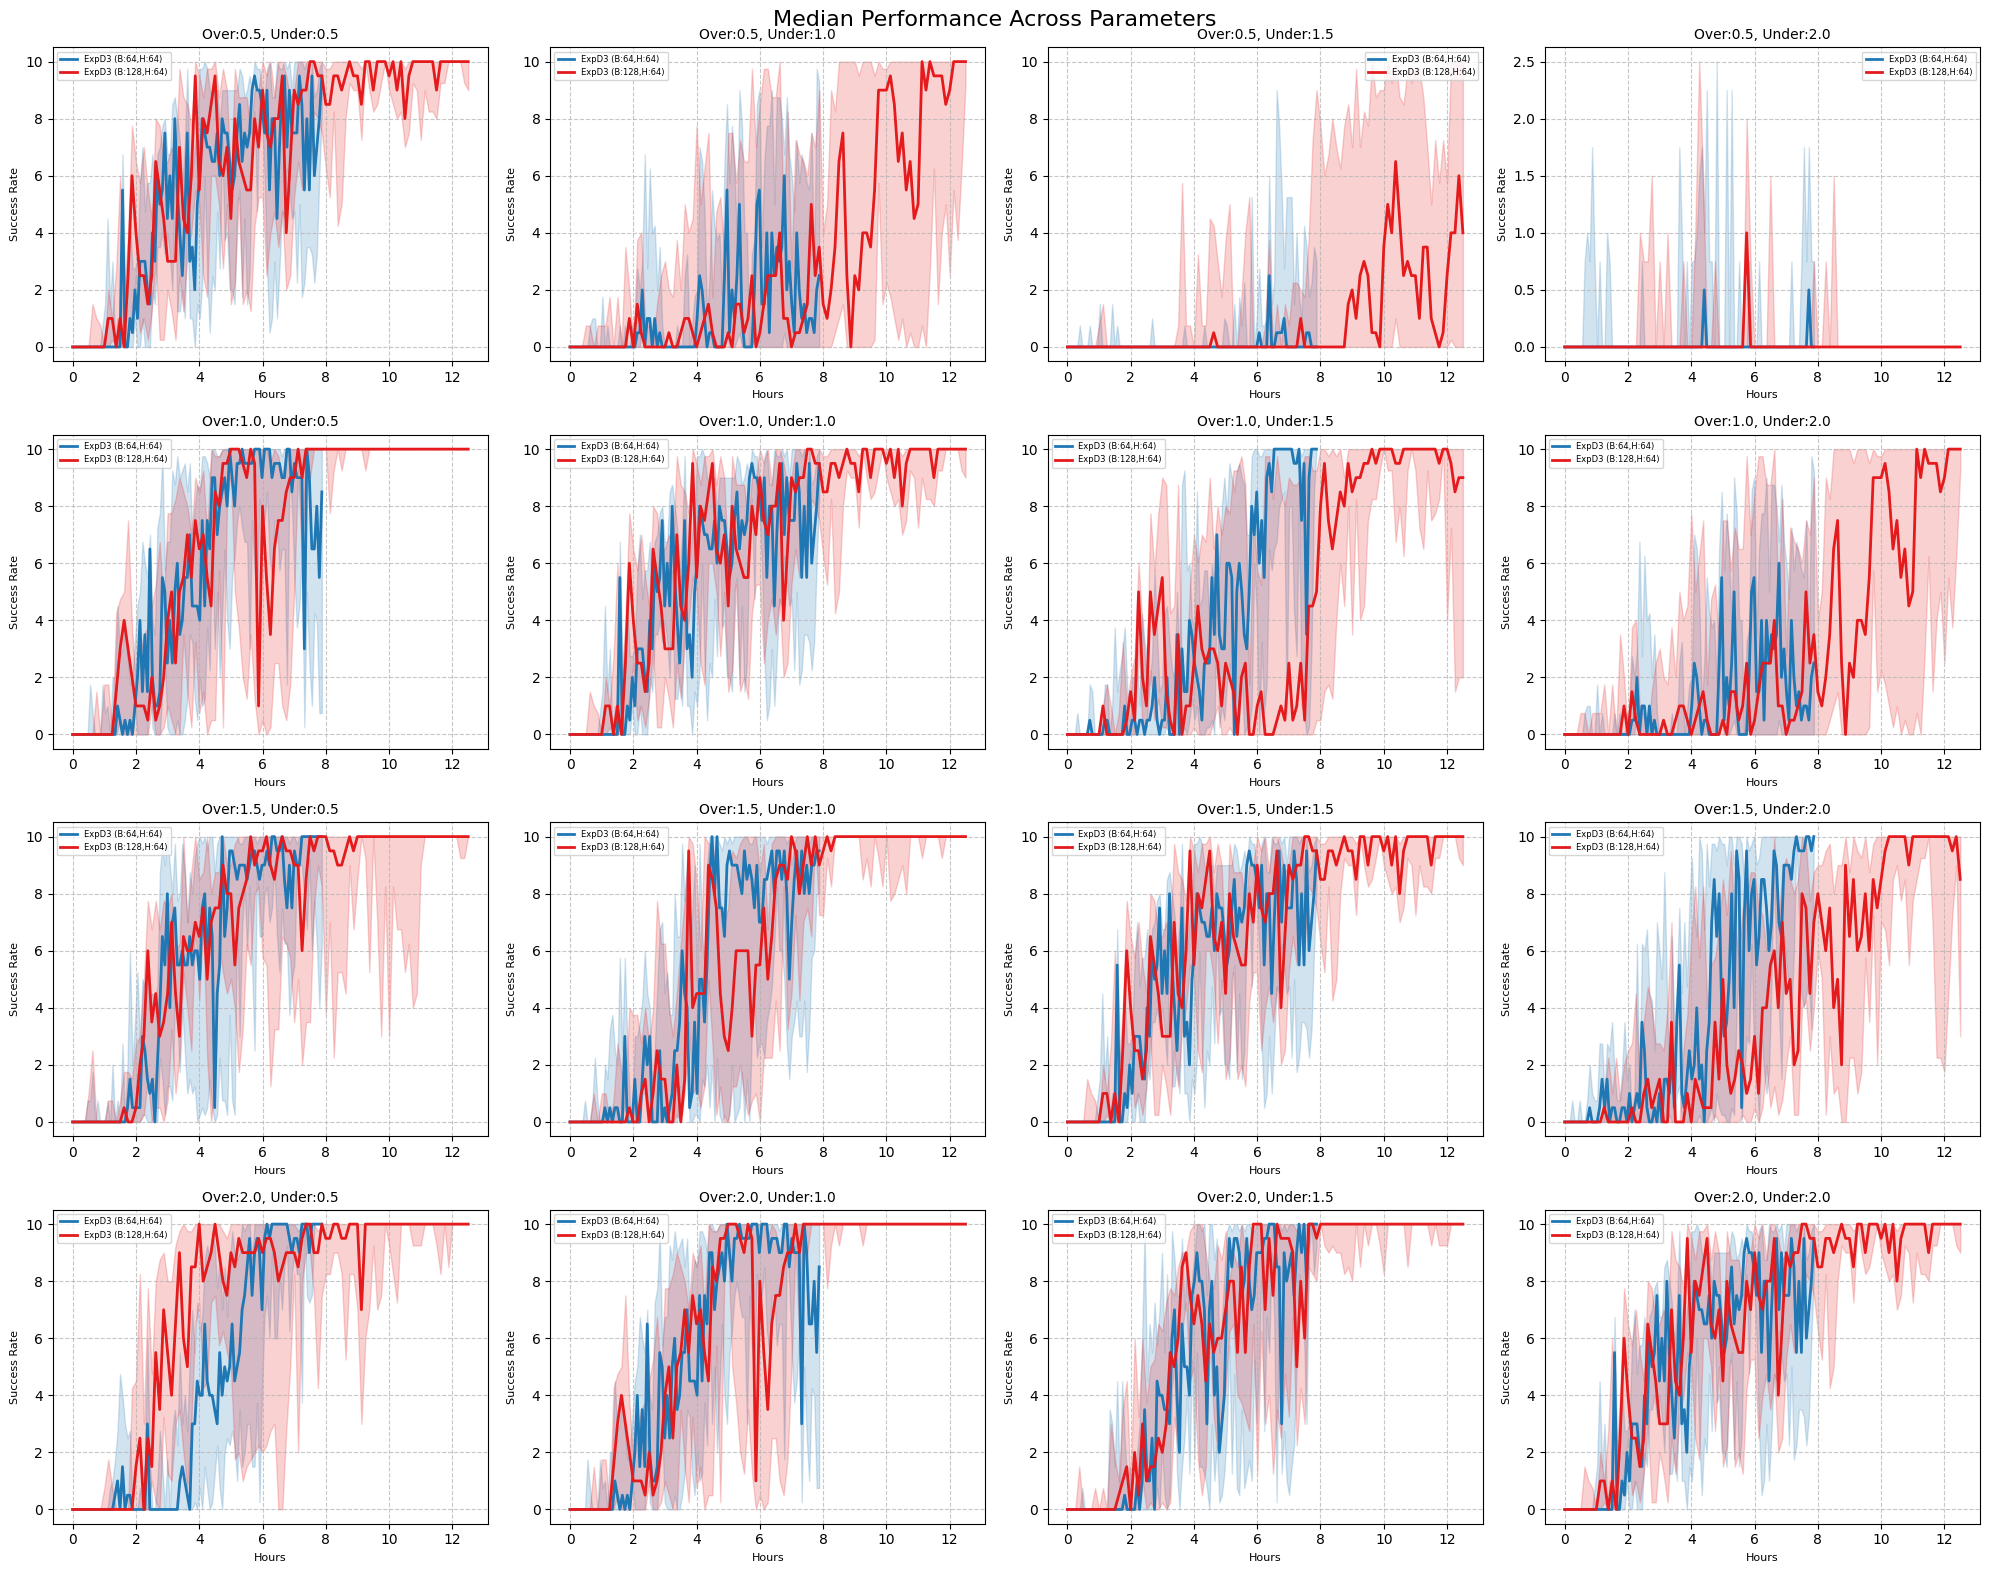

In [20]:
load_and_plot_results(path)